#  1:  Getting the data

By: Sharon Makunura

### About the Data

The data from this project was exported from WhatsApp as a text file.  The image below shows the basic format of the text file.  The original text file is NOT available for download.

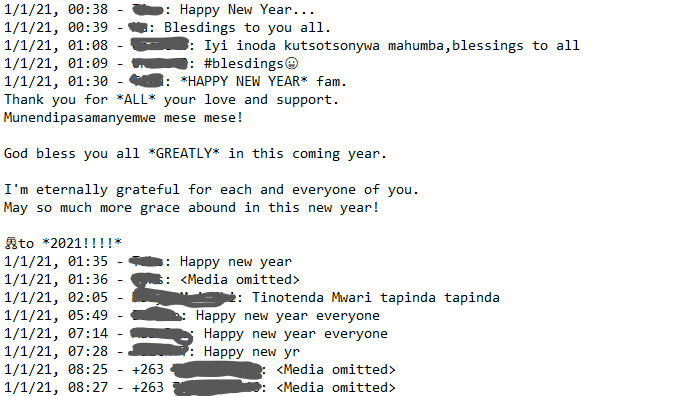

In order to utilize the data for analysis, the text file had to be converted to a pandas dataframe.  This notebook deals exclusively with how to extract data from a text file into a pandas dataframe.  

In [2]:
#import required libraries

import re
import pandas as pd
import numpy as np
from datetime import *
import datetime as dt
import regex
from nltk import *


In [4]:
#function to make comparison based on string value
#takes as input a string of data values and a pattern style for comparison

def matchFormat(values,style):                    #string data values = values and comparison pattern =style
     
        check = re.match(style, values)                 #check if values match pattern
        res = bool(check)                          #store results of match as bool
        
        return res                              #returns list of false matches as list
    

In [5]:
#define string patterns for dates and time

largedateTime_pattern= '^[0-9]+/[0-9]+/[0-9]+, [0-9][0-9]:[0-9][0-9]'           #format of date and time in original chat


In [ ]:
#NB: create list of contacts to be used to verify senders.  Variable must be list of strings.

In [6]:
contact_list=['Sharon', 'Connie', '+44 7904 966330', 'David', 'Maini Memo', 'Kudzi', '+44 7765 822192', 'Tino', 'Ma', 'Uncle B',
              'Taku', 'Taks', 'Mbuya Mai Chi', 'Bonnie', 'Mai Rue', 'Faith T', '+263 73 435 3446', 'Sta', 'Hillary Eco', 'Mkoma Addy',
              'Vari', 'Mainini Tsi', 'Ba Manasseh', 'MamMai Ti One', 'Rue', '+263 77 212 6054', 'Daddy Changie', 'Shumi', 'Katie', 'Manasseh',
              'Wellington', '+267 74 038 077', 'Munashe', 'Hluli', 'Panashe Jj', 'Ta', '+44 7763 580928', '+44 7725 790451', '+267 75 223 331',
              '+263 78 844 8500']

In [8]:
#save text file to dataframe

rows = []

with open ('WhatsApp Chat with Mhuri yedu.txt', encoding="utf-8") as chatfile:
    for chatline in chatfile:
                                                             
        firstSplit = chatline.partition(' - ')
        dateTime = firstSplit[0]
        
        #check validity of input as dateTime object using function
        
        isdateTime = matchFormat(dateTime,largedateTime_pattern)
        if isdateTime == True:
            #this is valid date time object therefore can be split into date and time object
            date,c,time = dateTime.partition(',')
            chat = firstSplit[2]
        else:                                               
            chat = dateTime                                 
            
        #edit the chat object to retrieve sender details
        
        sent_by, c, msg = chat.partition(':')
        
        #check if sender info has match in sender list 
       
        
        
        if sent_by in contact_list:                    #checks if its valid sender
            vSender = sent_by
            chat = msg
        else:
            vSender = 'MO'                              #Marks message as overflow
           
            
        
     
        
        rows.append([date, time,vSender,chat])
        
        
df = pd.DataFrame(rows, columns = ['Date', 'Time', 'Sender','Message'])
    
        
        

In [9]:
#remove line breaker characters

df['Message'] = df['Message'].str.strip('\n')

In [10]:
#remove blank rows; blank rows have empty message text
df.drop(df[df.Message == ''].index, inplace=True)
df=df.reset_index()
df.drop('index', axis=1,inplace=True)

In [ ]:
df.head(25)

The output for the preview shows the following.  
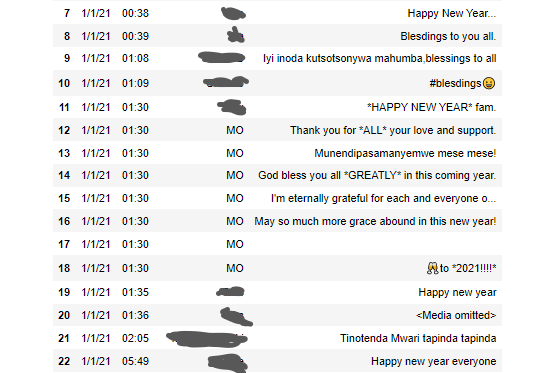

When compared with the image of the textfile it is clear that longer messages and blank lines were misassigned marked MO for overflow.  The bonus code below carries out several functions to clean up the dataframe if necessary, otherwise extracting a text file into a dataframe has been successfully completed.  

### Cleaning up the dataframe

In [17]:
#select all overflow messages into one dataframe

msg_overflow=df.loc[df['Sender']=='MO']                #actual dataframe

overflow_index = msg_overflow.index


In [18]:
#create function to find strings within a series

#takes a series, returns a series; selector is string of values to be checked

def stringCheck(data,selector):
    series_result = data.str.contains(selector)
    
    return series_result
    

In [19]:
#remove system messages like adding members or removing
#begin by checking for them and save to df
key_words = ' left| added| this group|changed the group|changed their phone number'
msg_overflow['System Message'] = stringCheck(msg_overflow['Message'], key_words)

In [20]:
#some messages shown as true are not but just contain the word left or added.  correct this via word count

msg_overflow['word_count'] = msg_overflow['Message'].str.split().map(len)

In [21]:
#save indexes of all erroneously marked messages and prepare for recheck
#tagged as system messages but messages appear too long
error_index=msg_overflow[(msg_overflow['word_count']>10)&(msg_overflow['System Message']==True)].index


In [22]:
#adjust entries such that true system messages are remarked true
last_check = 'Tap to message or add the new number'
for i in error_index:
    text=msg_overflow['Message'][i]
    txt=msg_overflow.at[i, 'System Message']
    msg_overflow.at[i, 'System Message'] = True if last_check in text else False

In [23]:
#generate index of rows to be dropped
drop_index=msg_overflow[msg_overflow['System Message']==True].index
#df=df.reset_index()

In [24]:
#drop the messages from the main dataframe and recreate message overflow
df.drop(df.index[drop_index], inplace=True)
df=df.reset_index()

In [25]:
#recreate message overflow

#select all overflow messages into one dataframe

msg_overflow=df.loc[df['Sender']=='MO']                #actual dataframe

overflow_index = msg_overflow.index

In [26]:
#group messages by date and time; then combine messages into one by joining all messages per group
#results in duplicates so drop them 

msg_overflow['Message']=msg_overflow.groupby(['Date','Time'])['Message'].transform(lambda x : ' '.join(x))

msg_overflow= msg_overflow.drop_duplicates(subset = 'Message', keep = 'first')

In [27]:
#get new list of indexes from updated message overflow df

new_overflow_index = msg_overflow.index

#create sent index (index of sending message, i.e preceding message) by calculating value of previous index which will be index - 1

sent_index = new_overflow_index-1


In [28]:
#rename message column
msg_overflow=msg_overflow.rename(columns={'Message':'Overflow'})


In [29]:
#adjust column named index to match original dataframe
msg_overflow['index']=sent_index
        

In [30]:
#remove other columns and leave key and message content
msg_overflow.drop(msg_overflow.iloc[:, 1:4], inplace = True, axis = 1)



In [31]:
#merge original dataframe with msg overflow column to create new column
counter_df= df.merge(msg_overflow,on='index', how='left')

In [32]:
#fill na with space then combine messages

counter_df=counter_df.fillna('')

#merge message and overflow

counter_df['Messages']=counter_df['Message']+''+counter_df['Overflow']


In [33]:
#drop other columns

whatsapp_df=counter_df.drop(counter_df.columns[[0,4,5]], axis=1)

In [34]:
#clean up final dataframe by removing all messages from MO and renaming messages column

whatsapp_df.drop(whatsapp_df[ whatsapp_df['Sender'] == 'MO' ].index,inplace = True)
whatsapp_df.rename(columns = {'Messages':'Chat'}, inplace =True)
#reset index
whatsapp_df=whatsapp_df.reset_index()
whatsapp_df.drop('index', axis=1, inplace = True)

In [ ]:

whatsapp_df.head(25)

The output for the preview below gives the following more organised dataframe.  
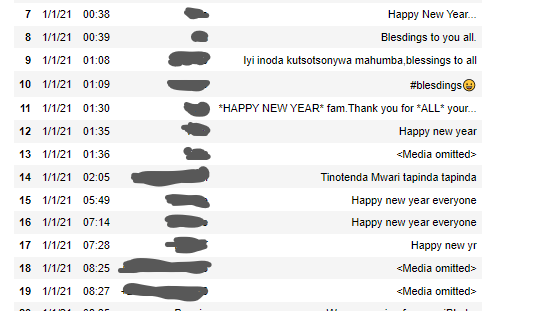

A few additional operations to finish up, setting date as date object and converting all words to lower case for easier comaparisons. 

In [36]:
#set date as date object
whatsapp_df['Date'] = pd.to_datetime(whatsapp_df['Date'])


In [ ]:
#replace media omitted with media shared
whatsapp_df=whatsapp_df.replace(to_replace =[' <Media omitted>'], 
                            value =' Media shared')

In [37]:
whatsapp_df['Chat']=whatsapp_df['Chat'].str.lower()


In [38]:
whatsapp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3385 entries, 0 to 3384
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    3385 non-null   datetime64[ns]
 1   Time    3385 non-null   object        
 2   Sender  3385 non-null   object        
 3   Chat    3385 non-null   object        
dtypes: datetime64[ns](1), object(3)
memory usage: 105.9+ KB


End of Part One Notebook 1